## Telecom Churn Modeling
### Openly Take Home Challenge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

% matplotlib inline

### Table of Contents

- Problem Statment
- Getting the Data
- Data Cleaning
- Data Exploration
- Data Transformation
- Model Testing
- Hyperparameter Tuning

### Problem Statement & Objective

A telecom provider would like to better understand its customer base and would like to know who are most likely to drop out from their service. The objective of this exercise is to understand what factors are driving customer churn and how the company can improve customer retention.

A supervised classification modeling approach will be used to try to identify the underlying patterns and signal, if any, present within the data. It is assumed no previous efforts have been made regarding estimating churn propensity. A baseline result/statistic of the most common outcome will be used to gauge performance of more complex models.

### Getting the Data
#### Data Dictionary

In [2]:
# directory where data is stored
data_dir = 'data/'

In [3]:
data_dct = pd.read_csv(data_dir + 'data_dictionary.csv', encoding='ISO-8859-1')
data_dct.drop('S.No.', axis=1, inplace=True)
data_dct.columns = ['variable_name', 'definition']
data_dct_styler = data_dct.style.set_properties(**{'text-align': 'left'})
display(data_dct_styler.hide_index())

variable_name,definition
CustomerID,The unique ID of each customer
Gender,The gender of a person
SeniorCitizen,Whether a customer can be classified as a senior citizen.
Partner,If a customer is married/ in a live-in relationship.
Dependents,If a customer has dependents (children/ retired parents)
Tenure,The time for which a customer has been using the service.
PhoneService,Whether a customer has a landline phone service along with the internet service.
MultipleLines,Whether a customer has multiple lines of internet connectivity.
InternetService,The type of internet services chosen by the customer.
OnlineSecurity,Specifies if a customer has online security.


Potential multicolinearity between the following variable pairs:
- `Partner` : `Dependents`
- `OnlineSecurity` : `OnlineBackup`
- `Tenure` : `TotalCharges`

In [4]:
# used in README file
print(data_dct.to_markdown(index=False))

| variable_name    | definition                                                                       |
|:-----------------|:---------------------------------------------------------------------------------|
| CustomerID       | The unique ID of each customer                                                   |
| Gender           | The gender of a person                                                           |
| SeniorCitizen    | Whether a customer can be classified as a senior citizen.                        |
| Partner          | If a customer is married/ in a live-in relationship.                             |
| Dependents       | If a customer has dependents (children/ retired parents)                         |
| Tenure           | The time for which a customer has been using the service.                        |
| PhoneService     | Whether a customer has a landline phone service along with the internet service. |
| MultipleLines    | Whether a customer has multiple lines of in

In [5]:
import re

def camel_to_snake(t):
    ''' https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case '''
    s = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', t)
    s = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s).lower()
    return s

In [6]:
df_customer = pd.read_csv(data_dir + 'customer_data.csv')
df_customer.columns = [camel_to_snake(x) for x in df_customer.columns]

df_internet = pd.read_csv(data_dir + 'internet_data.csv')
df_internet.columns = [camel_to_snake(x) for x in df_internet.columns]

df_churn = pd.read_csv(data_dir + 'churn_data.csv')
df_churn.columns = [camel_to_snake(x) for x in df_churn.columns]

In [7]:
df = df_customer.merge(df_internet, on='customer_id').merge(df_churn, on='customer_id')
df.drop('customer_id', axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   multiple_lines     7043 non-null   object 
 5   internet_service   7043 non-null   object 
 6   online_security    7043 non-null   object 
 7   online_backup      7043 non-null   object 
 8   device_protection  7043 non-null   object 
 9   tech_support       7043 non-null   object 
 10  streaming_tv       7043 non-null   object 
 11  streaming_movies   7043 non-null   object 
 12  tenure             7043 non-null   int64  
 13  phone_service      7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

In [9]:
df.head()

,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,tenure,phone_service,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,No phone service,DSL,No,Yes,No,No,No,No,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data Cleaning

In [10]:
df_clean = df.copy()

In [11]:
# provides ValueError: Unable to parse string " " at position 488
# df[['total_charges']] = df[['total_charges']].apply(pd.to_numeric)

In [12]:
df_clean.total_charges[488]

' '

In [13]:
# replace blank strings with '0' and then convert column to numeric (float)
df_clean.total_charges = df_clean.total_charges.replace([' '], '0')
df_clean[['total_charges']] = df_clean[['total_charges']].apply(pd.to_numeric)

In [14]:
df_clean.total_charges.dtype

dtype('float64')

In [15]:
categorical_features = ['internet_service', 'contract', 'payment_method']
boolean_features = ['gender', 'senior_citizen', 'partner', 'dependents','multiple_lines', 'online_security', \
                    'online_backup', 'phone_service', 'paperless_billing',  'device_protection', \
                    'tech_support', 'streaming_tv', 'streaming_movies', 'churn']

In [16]:
def boolean_encode(df, cols):
    for col in cols:
        df[col] = np.where((df[col] == 'Male') | (df[col] == 'Yes') | (df[col] == 1), 1, 0)
    return df

In [17]:
df_clean = boolean_encode(df_clean, boolean_features)

In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   int64  
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   int64  
 3   dependents         7043 non-null   int64  
 4   multiple_lines     7043 non-null   int64  
 5   internet_service   7043 non-null   object 
 6   online_security    7043 non-null   int64  
 7   online_backup      7043 non-null   int64  
 8   device_protection  7043 non-null   int64  
 9   tech_support       7043 non-null   int64  
 10  streaming_tv       7043 non-null   int64  
 11  streaming_movies   7043 non-null   int64  
 12  tenure             7043 non-null   int64  
 13  phone_service      7043 non-null   int64  
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   int64  
 16  payment_method     7043 

In [19]:
df_dummies = pd.get_dummies(df_clean[categorical_features])
df_dummies.columns = [c.lower().replace(' ', '_').replace('-', '_').replace(')','').replace('(','') \
                      for c in df_dummies.columns]

In [20]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   internet_service_dsl                    7043 non-null   uint8
 1   internet_service_fiber_optic            7043 non-null   uint8
 2   internet_service_no                     7043 non-null   uint8
 3   contract_month_to_month                 7043 non-null   uint8
 4   contract_one_year                       7043 non-null   uint8
 5   contract_two_year                       7043 non-null   uint8
 6   payment_method_bank_transfer_automatic  7043 non-null   uint8
 7   payment_method_credit_card_automatic    7043 non-null   uint8
 8   payment_method_electronic_check         7043 non-null   uint8
 9   payment_method_mailed_check             7043 non-null   uint8
dtypes: uint8(10)
memory usage: 443.8 KB


In [21]:
df_clean = pd.concat([df_clean, df_dummies], axis=1)
df_clean = df_clean.drop(categorical_features, axis=1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  7043 non-null   int64  
 1   senior_citizen                          7043 non-null   int64  
 2   partner                                 7043 non-null   int64  
 3   dependents                              7043 non-null   int64  
 4   multiple_lines                          7043 non-null   int64  
 5   online_security                         7043 non-null   int64  
 6   online_backup                           7043 non-null   int64  
 7   device_protection                       7043 non-null   int64  
 8   tech_support                            7043 non-null   int64  
 9   streaming_tv                            7043 non-null   int64  
 10  streaming_movies                        7043 non-null   int6

In [22]:
df_clean.head()

,gender,senior_citizen,partner,dependents,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,...,internet_service_dsl,internet_service_fiber_optic,internet_service_no,contract_month_to_month,contract_one_year,contract_two_year,payment_method_bank_transfer_automatic,payment_method_credit_card_automatic,payment_method_electronic_check,payment_method_mailed_check
0,0,0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,1,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,0,1,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [23]:
corr_matrix = df_clean.corr()
corr_matrix['churn'].sort_values()

tenure                                   -0.352229
contract_two_year                        -0.302253
internet_service_no                      -0.227890
total_charges                            -0.198324
contract_one_year                        -0.177820
online_security                          -0.171226
tech_support                             -0.164674
dependents                               -0.164221
partner                                  -0.150448
payment_method_credit_card_automatic     -0.134302
internet_service_dsl                     -0.124214
payment_method_bank_transfer_automatic   -0.117937
payment_method_mailed_check              -0.091683
online_backup                            -0.082255
device_protection                        -0.066160
gender                                   -0.008612
phone_service                             0.011942
multiple_lines                            0.040102
streaming_movies                          0.061382
streaming_tv                   

In [24]:
cols_to_drop = [
    'payment_method_credit_card_automatic',
    'internet_service_dsl',
    'payment_method_bank_transfer_automatic',
    'payment_method_mailed_check',
    'online_backup', 
    'device_protection',
    'gender',
    'phone_service',
    'multiple_lines',
    'streaming_movies',
    'streaming_tv'
]

df_clean = df_clean.drop(cols_to_drop, axis=1)

In [25]:
corr_matrix = df_clean.corr()
corr_matrix['churn'].sort_values()

tenure                            -0.352229
contract_two_year                 -0.302253
internet_service_no               -0.227890
total_charges                     -0.198324
contract_one_year                 -0.177820
online_security                   -0.171226
tech_support                      -0.164674
dependents                        -0.164221
partner                           -0.150448
senior_citizen                     0.150889
paperless_billing                  0.191825
monthly_charges                    0.193356
payment_method_electronic_check    0.301919
internet_service_fiber_optic       0.308020
contract_month_to_month            0.405103
churn                              1.000000
Name: churn, dtype: float64

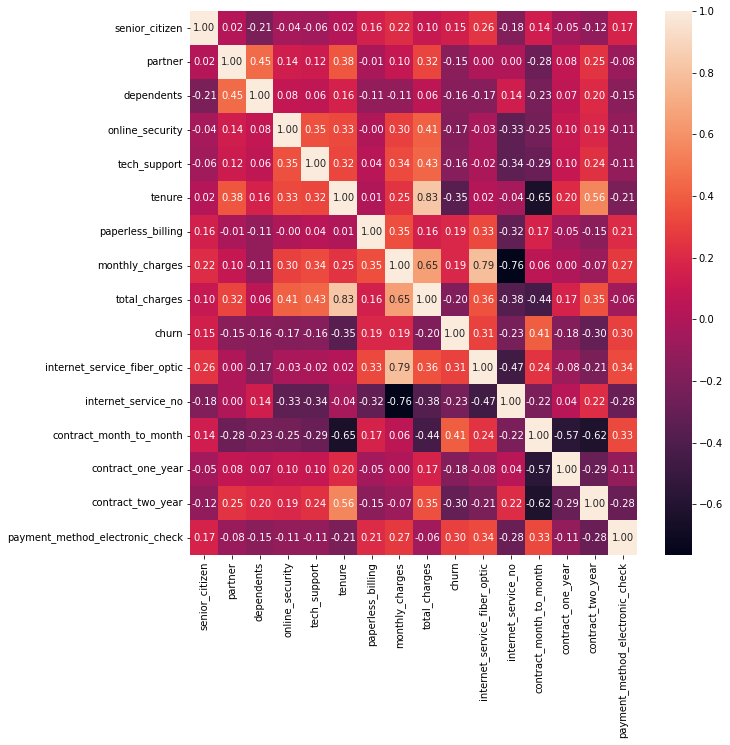

In [26]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

In [27]:
# droping total_charges to avoid any issues with multicollinearity with tenure
df_clean.drop('total_charges', axis=1, inplace=True)

In [28]:
final_columns = df_clean.columns.tolist()
final_columns

['senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'tech_support',
 'tenure',
 'paperless_billing',
 'monthly_charges',
 'churn',
 'internet_service_fiber_optic',
 'internet_service_no',
 'contract_month_to_month',
 'contract_one_year',
 'contract_two_year',
 'payment_method_electronic_check']

### Data Cleaning

#### Use the final set of features to clean the dataframe

In [29]:
final_columns = [
    'senior_citizen',
    'partner',
    'dependents',
    'online_security',
    'tech_support',
    'tenure',
    'paperless_billing',
    'monthly_charges',
    'churn',
    'internet_service_fiber_optic',
    'internet_service_no',
    'contract_month_to_month',
    'contract_one_year',
    'contract_two_year',
    'payment_method_electronic_check'
]

In [30]:
def clean_data(df, cols):
    boolean_cols = ['churn', 'senior_citizen', 'partner', 'dependents', 'online_security', \
                    'tech_support', 'paperless_billing']
    for b in boolean_cols:
        df[b] = np.where((df[b] == 'Yes') | (df[b] == 1), 1, 0)
    
    categorical_cols = ['internet_service', 'contract', 'payment_method']
    dummies = pd.get_dummies(df[categorical_cols])
    dummies.columns = [c.lower().replace(' ', '_').replace('-', '_').replace(')','').replace('(','') \
                       for c in dummies.columns]
    
    df = pd.concat([df, dummies], axis=1)
    df = df[cols]

    return df

In [31]:
df = clean_data(df, final_columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   senior_citizen                   7043 non-null   int64  
 1   partner                          7043 non-null   int64  
 2   dependents                       7043 non-null   int64  
 3   online_security                  7043 non-null   int64  
 4   tech_support                     7043 non-null   int64  
 5   tenure                           7043 non-null   int64  
 6   paperless_billing                7043 non-null   int64  
 7   monthly_charges                  7043 non-null   float64
 8   churn                            7043 non-null   int64  
 9   internet_service_fiber_optic     7043 non-null   uint8  
 10  internet_service_no              7043 non-null   uint8  
 11  contract_month_to_month          7043 non-null   uint8  
 12  contract_one_year   

### Data Exploration

In [32]:
print('Churn rate: {:.2f}%'.format(100 * df.churn.value_counts()[1] / df.shape[0]))

Churn rate: 26.54%


<AxesSubplot:>

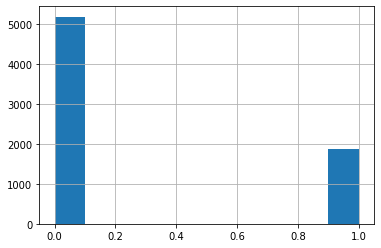

In [33]:
df.churn.hist()

A naive estimator that predicts the most common outcome (not churned) would have accuracy equal to the inverse of the churn rate (100% - 25.54% = 74.46%). This value can be used as a baseline result while building and testing models. The baseline result provides a meaningful reference point from which to compare estimators.

In [34]:
df.describe()

,senior_citizen,partner,dependents,online_security,tech_support,tenure,paperless_billing,monthly_charges,churn,internet_service_fiber_optic,internet_service_no,contract_month_to_month,contract_one_year,contract_two_year,payment_method_electronic_check
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,0.286668,0.290217,32.371149,0.592219,64.761692,0.265370,0.439585,0.216669,0.550192,0.209144,0.240664,0.335794
std,0.368612,0.499748,0.458110,0.452237,0.453895,24.559481,0.491457,30.090047,0.441561,0.496372,0.412004,0.497510,0.406726,0.427517,0.472301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,35.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,70.350000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,55.000000,1.000000,89.850000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,118.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
df.groupby('churn')[['tenure', 'monthly_charges']].mean()

,tenure,monthly_charges
churn,,
0,37.569965,61.265124
1,17.979133,74.441332


- Not surprisingly, customers with higher tenure churn less often than customers with lower tenure
- Average monthly charges are $13 more for churned customers than current customers

In [36]:
df.groupby('senior_citizen')[['tenure', 'monthly_charges', 'churn']].mean()

,tenure,monthly_charges,churn
senior_citizen,,,
0,32.192171,61.847441,0.236062
1,33.295972,79.820359,0.416813


- senior citizens are almost twice as likely to churn as younger customers
- senior citizen are charged $18 more per month on average

In [37]:
df.groupby('tech_support')[['tenure', 'monthly_charges', 'churn']].mean()

,tenure,monthly_charges,churn
tech_support,,,
0,27.279856,58.252931,0.311862
1,44.822896,80.680137,0.151663


- even though their monthly charges are higher, customers who opt for tech support are half as likely to churn

In [38]:
df.groupby('contract_month_to_month')[['tenure', 'monthly_charges', 'churn']].mean()

,tenure,monthly_charges,churn
contract_month_to_month,,,
0,49.904672,62.759612,0.067551
1,18.036645,66.398490,0.427097


- customers with month-to-month contracts are much more likely to churn than customers with one or two-year contracts

In [39]:
df.groupby('payment_method_electronic_check')[['tenure', 'monthly_charges', 'churn']].mean()

,tenure,monthly_charges,churn
payment_method_electronic_check,,,
0,36.009406,58.950748,0.170586
1,25.174630,76.255814,0.452854


In [40]:
df.payment_method_electronic_check.value_counts()

0    4678
1    2365
Name: payment_method_electronic_check, dtype: int64

- customers that pay by electonic check have higher monthly charges but are much more likely to churn

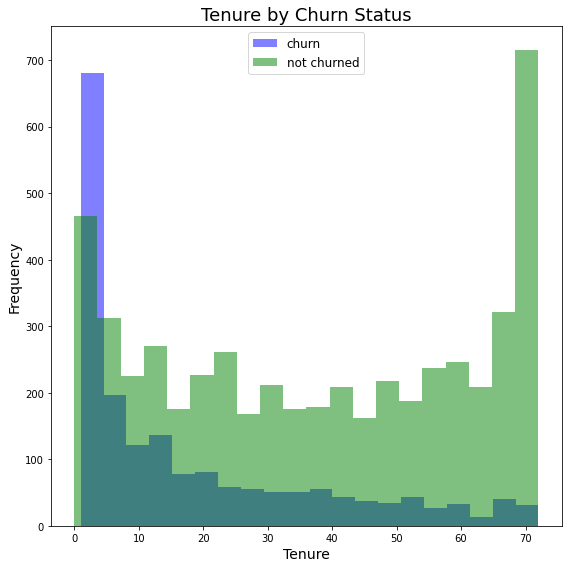

In [41]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

tenure_churn = df.tenure[df.churn == 1]
tenure_active = df.tenure[df.churn == 0]

ax.hist(tenure_churn.values, color='b', alpha=0.5, bins=20, label='churn')
ax.hist(tenure_active.values, color='g', alpha=0.5, bins=20, label='not churned')

ax.set_xlabel('Tenure', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Tenure by Churn Status', fontsize=18)
ax.legend(fontsize=12)

plt.tight_layout()

### Data Transformation

In [42]:
y = df.pop('churn')
X = df

In [43]:
numeric_features = ['tenure', 'monthly_charges']
boolean_features = [c for c in X.columns if c not in numeric_features]

In [44]:
# split data into training and test sets, stratify by target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [45]:
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('bool', boolean_transformer, boolean_features),
        ('num', numeric_transformer, numeric_features)
    ])

### Model Testing

#### Logistic Regression

In [46]:
logreg = LogisticRegression(random_state=1)

logreg_pipeline = Pipeline(steps=[
    ('p', preprocessor),
    ('m', logreg)
])

In [47]:
logreg_scores = cross_val_score(logreg_pipeline, X_train, y_train, scoring='accuracy')
print('Logistic Regression mean CV accuracy: {:2f}%'.format(np.mean(logreg_scores) * 100))

Logistic Regression mean CV accuracy: 79.907534%


#### Random Forest Classifier

In [48]:
rf_clf = RandomForestClassifier(n_jobs=-2, random_state=1)

rf_pipeline = Pipeline(steps=[
    ('p', preprocessor),
    ('m', rf_clf)
])

In [49]:
rf_scores = cross_val_score(rf_pipeline, X_train, y_train, scoring='accuracy')
print('Random Forest mean CV accuracy: {:2f}%'.format(np.mean(rf_scores) * 100))

Random Forest mean CV accuracy: 78.168104%


### Hyperparameter Tuning
#### Run a gridsearch to determine best parameters

In [50]:
def run_gridsearch(model, param_grid, X, y, scoring='accuracy', cv=5, n_jobs=1, verbose=1):
    gs = GridSearchCV(
        model,
        param_grid,
        n_jobs=n_jobs,
        verbose=verbose,
        scoring=scoring,
        cv=cv
    )
    
    gs.fit(X,y)
    best_params = gs.best_params_
    best_model = gs.best_estimator_
    
    print('\nResults of Gridsearch:')
    print('{0:<40s} | {1:<20s} | {2}'.format('Parameter', 'Optimal', 'GS Values'))
    print('-' * 80)
    for param, vals in param_grid.items():
        print('{0:<40s} | {1:<20s} | {2}'.format(str(param), str(best_params[param]), str(vals)))
              
    return best_model

In [51]:
logreg_params = {
    'm__C': [0.01, 0.1, 1, 10, 100],
    'm__tol': [0.0001, 0.001, 0.001, 0.01],
    'm__class_weight': ['balanced', None],
    'm__max_iter': [100, 200, 500]
}

In [52]:
rf_params = {
    'm__n_estimators': [200, 500],
    'm__max_depth': [6, 8],
    'm__min_samples_split': [2, 5, 10],
    'm__min_samples_leaf': [1, 2, 10],
    'm__class_weight': ['balanced', None]
}

In [53]:
logreg_best = run_gridsearch(
    logreg_pipeline,
    logreg_params,
    X_train,
    y_train
)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Results of Gridsearch:
Parameter                                | Optimal              | GS Values
--------------------------------------------------------------------------------
m__C                                     | 0.1                  | [0.01, 0.1, 1, 10, 100]
m__tol                                   | 0.0001               | [0.0001, 0.001, 0.001, 0.01]
m__class_weight                          | None                 | ['balanced', None]
m__max_iter                              | 100                  | [100, 200, 500]


In [54]:
rf_best = run_gridsearch(
    rf_pipeline,
    rf_params,
    X_train,
    y_train
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Results of Gridsearch:
Parameter                                | Optimal              | GS Values
--------------------------------------------------------------------------------
m__n_estimators                          | 200                  | [200, 500]
m__max_depth                             | 8                    | [6, 8]
m__min_samples_split                     | 10                   | [2, 5, 10]
m__min_samples_leaf                      | 1                    | [1, 2, 10]
m__class_weight                          | None                 | ['balanced', None]


#### Scoring best models on test set

In [55]:
print(classification_report(y_test, logreg_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [56]:
print(classification_report(y_test, rf_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

